<a href="https://colab.research.google.com/github/josemarcosrf/NeuralImageSuperResolution/blob/master/Latent_Diffusion_Upscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font face="Trebuchet MS" size="6">Neural Image Super-Resolution<font color="#999" size="4">&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;</font><font color="#999" size="4">Latent Diffusion upscale</font><font color="#999" size="4">&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;</font><a href="https://github.com/olaviinha/NeuralImageSuperResolution" target="_blank"><font color="#999" size="4">Github</font></a>

This notebook implements Superresolution Upscale from [Latent Diffusion](https://github.com/CompVis/latent-diffusion) in an attempt to improve and enhance image quality.

`input` may be a file path or a directory path. All paths should berelative to your Google Drive root. I.e. if your Google Drive has a directory called _images_ and under that directory you have a file _face.jpg_, then `input` value should be `images/face.jpg`

In [11]:
#@title #Setup
#@markdown This cell needs to be run only once. It will mount your Google Drive and setup prerequisites.<br>
#@markdown <small>Mounting Drive will enable this notebook to save outputs directly to your Drive. Otherwise you will need to copy/download them manually from this notebook.</small>

force_setup = False
mount_drive = True #@param {type:"boolean"}

# Download the repo from Github
import os
import warnings
import time, sys
import ipywidgets as widgets

from google.colab import output
from datetime import timedelta
from IPython.display import display

warnings.filterwarnings('ignore')

#-- start --
%cd /content/

# inhagcutils
if not os.path.isfile('/content/inhagcutils.ipynb') and force_setup == False:
  !curl -s -O https://raw.githubusercontent.com/olaviinha/inhagcutils/master/inhagcutils.ipynb


# Main python deps
!pip -q install \
    'import-ipynb' \
    'omegaconf>=2.0.0' \
    'pytorch-lightning<1.8.0' \
    'torch-fidelity' \
    'einops'

!pip install 'torch<2.0' torchvision functorch \
    --extra-index-url https://download.pytorch.org/whl/cu117


import import_ipynb
from inhagcutils import *


# Taming Transformers
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers

sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan # checking correct import from taming

# Latent Diffusion
!git clone 'https://github.com/CompVis/latent-diffusion.git'
%cd latent-diffusion

from notebook_helpers import get_model
from notebook_helpers import run

mode = widgets.Select(options=['superresolution'], value='superresolution', description='Task:')
model = get_model(mode.value)


import torch
import numpy as np
from PIL import Image

#-- end --


# Mount Drive
if mount_drive is True:
  if not os.path.isdir('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
    drive_root = '/content/drive/My Drive'
  if not os.path.isdir('/content/mydrive'):
    os.symlink('/content/drive/My Drive', '/content/mydrive')
    drive_root = '/content/mydrive/'
  drive_root_set = True
else:
  create_dirs(['/content/faux_drive'])
  drive_root = '/content/faux_drive/'

output.clear()
!nvidia-smi
op(c.ok, 'Setup finished.')

Tue Apr 18 18:45:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W /  70W |   1227MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

in: /content/mydrive/Media/Images/Floel2_fields_at_sunset_time.png


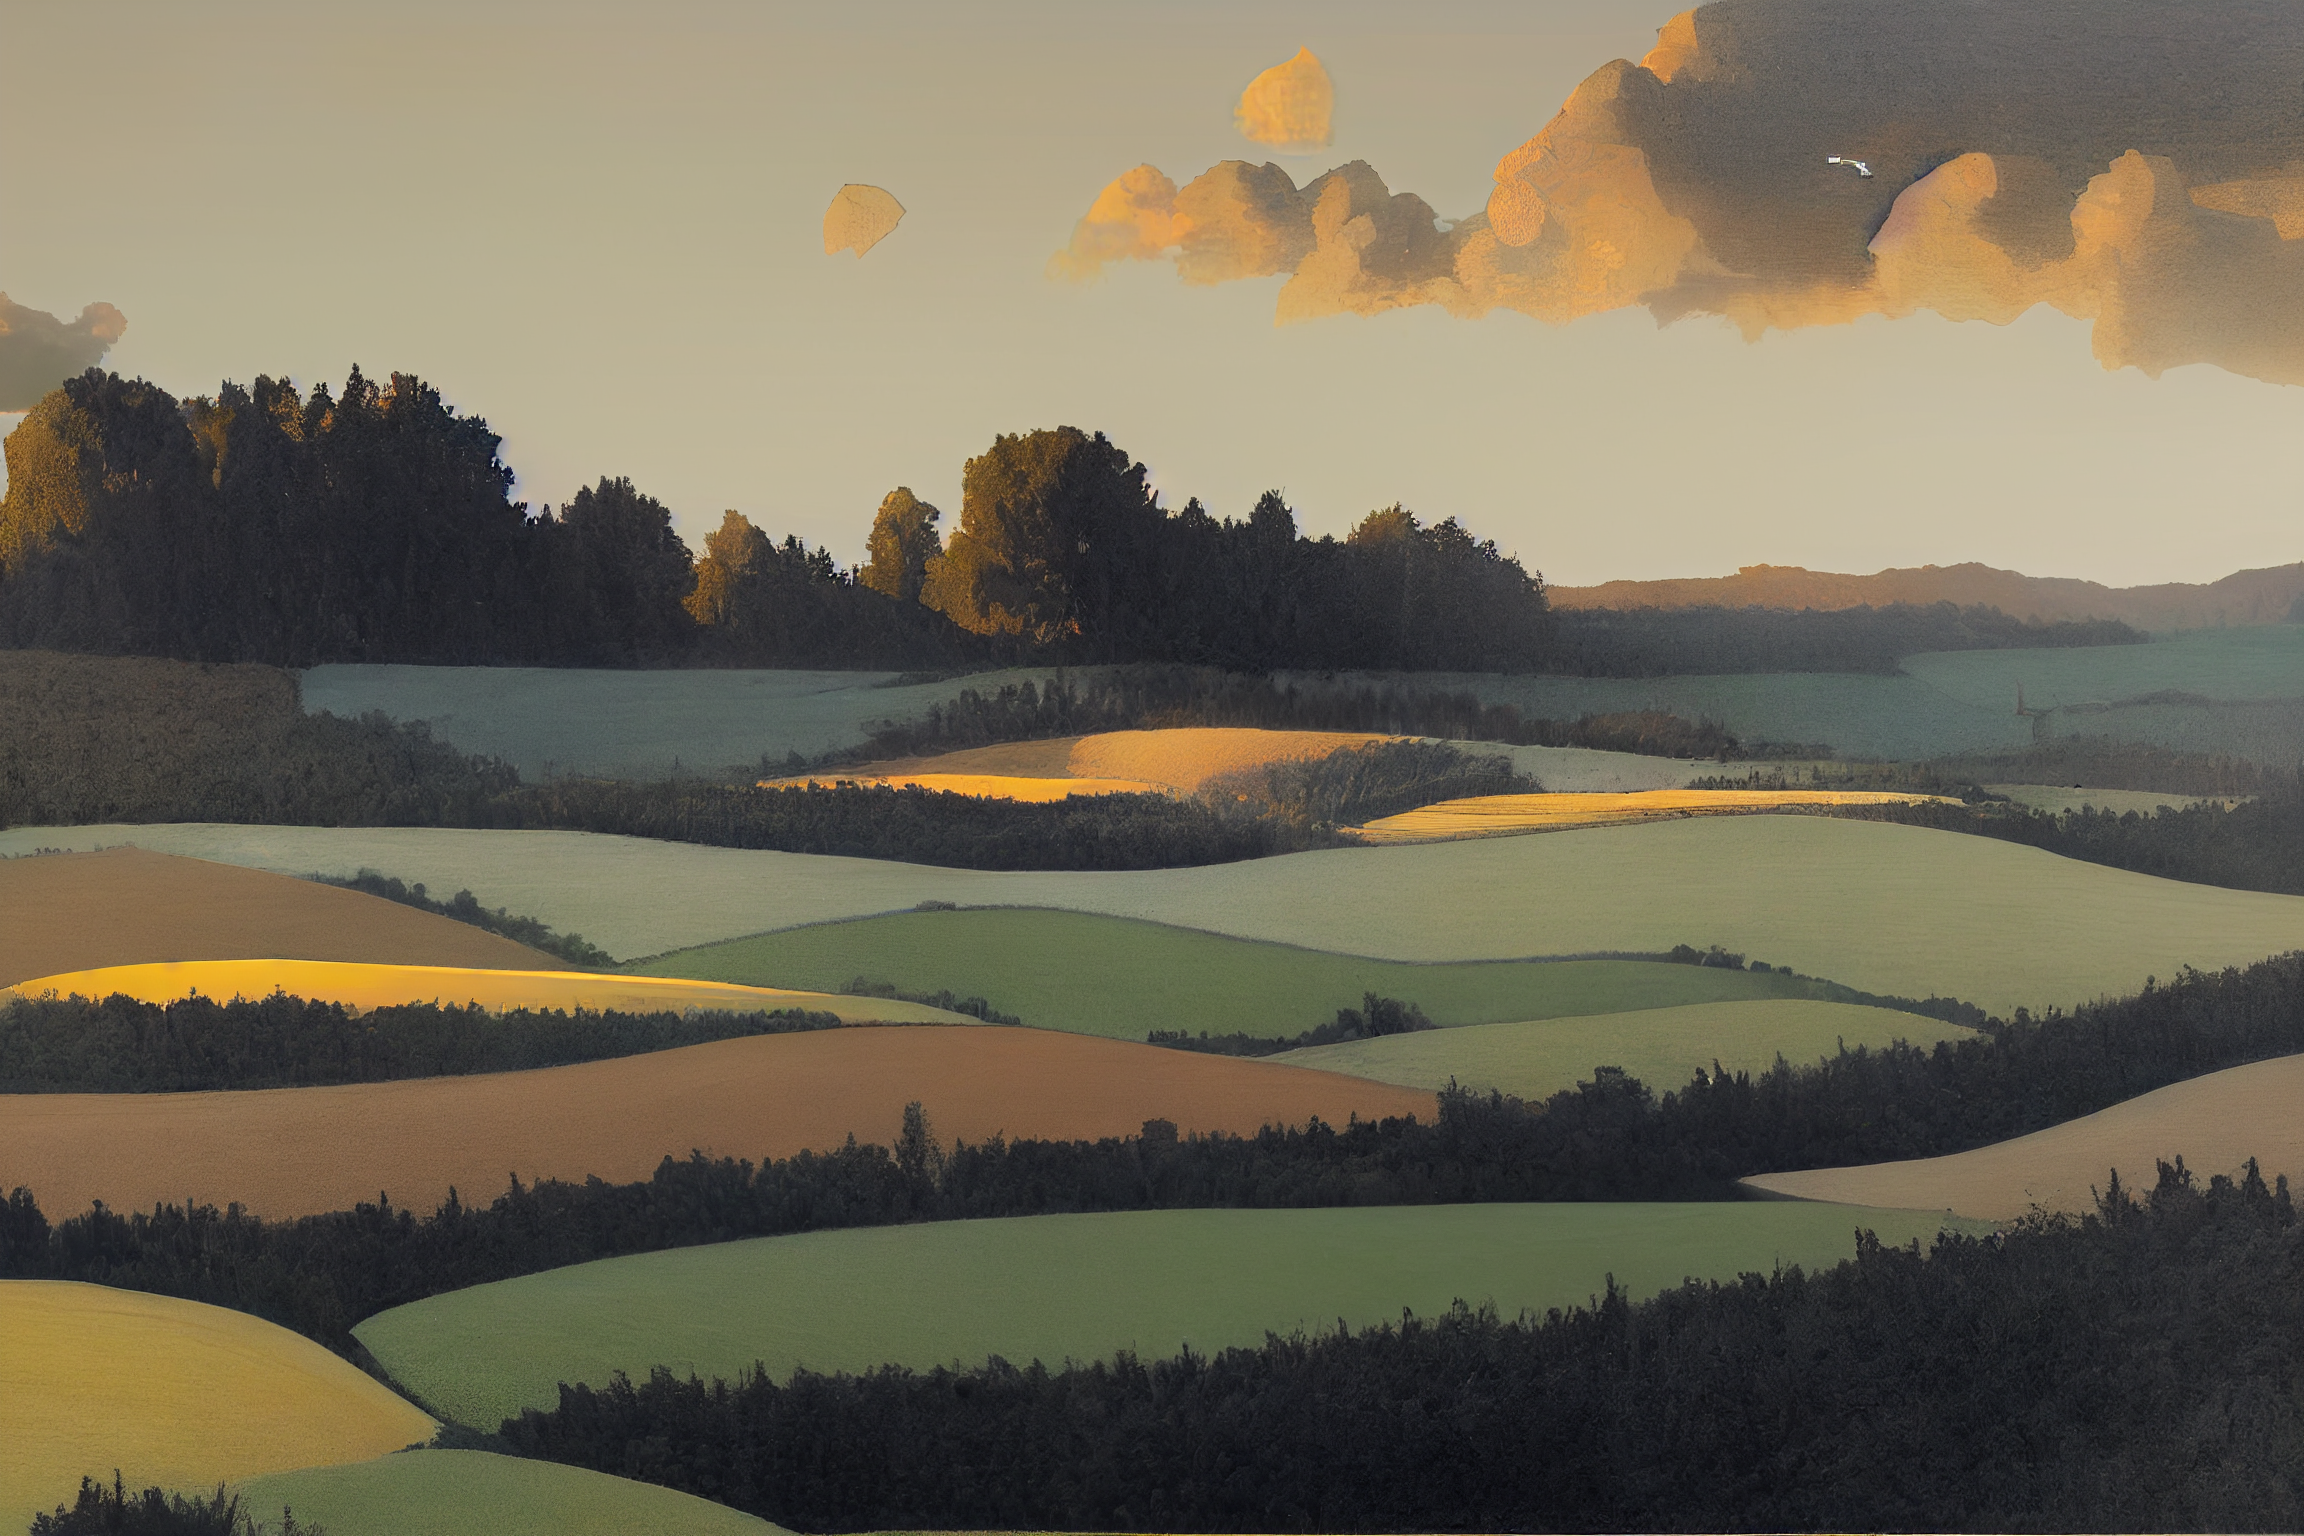

In [ ]:
#@title # Do stuff
input = "Media/Images" #@param {type:"string"}
output_dir = "Media/Images/Latent-Diffusion-Upscale" #@param {type:"string"}
steps = 100 #@param {type:"integer"}

uniq_id = gen_id()

if os.path.isfile(drive_root+input):
  inputs = [drive_root+input]
  dir_in = path_dir(drive_root+input)
elif os.path.isdir(drive_root+input):
  dir_in = drive_root+fix_path(input)
  # What to do if input is directory path
  inputs = list_images(dir_in)
elif os.path.isdir(drive_root+input) and '*' in input:
  dir_in = path_dir(drive_root+input)
  inputs = glob(drive_root+input)
else:
  op(c.fail, 'FAIL!', 'Input should be a path to an image file or a directory of image files.')
  sys.exit('Input not understood.')

# Output
if output_dir == '':
  dir_out = dir_in
else:
  if not os.path.isdir(drive_root+output_dir):
    os.mkdir(drive_root+output_dir)
  dir_out = drive_root+fix_path(output_dir)
  
timer_start = time.time()

# -- DO THINGS --
for input in inputs:
  print('in:', input )
  img_out = dir_out+uniq_id+'_'+str(steps)+'steps_'+path_leaf(input)
  

  logs = run(model["model"], input, mode.value, steps)

  sample = logs["sample"]
  sample = sample.detach().cpu()
  sample = torch.clamp(sample, -1., 1.)
  sample = (sample + 1.) / 2. * 255
  sample = sample.numpy().astype(np.uint8)
  sample = np.transpose(sample, (0, 2, 3, 1))
  a = Image.fromarray(sample[0])
  a.save(img_out)
  display(a)

  if os.path.isfile(img_out):
    op(c.ok, 'Upscaled image saved as', img_out.replace(drive_root, ''))
  else:
    op(c.fail, 'Error occurred: ', input.replace(drive_root, ''))
  
# -- END THINGS --

timer_end = time.time()

print('\nElapsed', timedelta(seconds=timer_end-timer_start))
op(c.ok, 'FIN.')
